# Advanced Lane Line Finding Project

For the advanced lane finding I use a processing pipeline consisting of the following building blocks:
- Camera Calibration to undistort images
- Image warping to transform into birds eye view
- Feature extraction to obtain pixels likely to be lanes
- Lane fitting and tracking
- Video processing

## Helper functions
For convenience some general helper functions

In [ ]:
def add_image_label(image, label, base=(30,90), scale=2, thickness=4):
    image_text = np.copy(image)
    fontface = cv2.FONT_HERSHEY_SIMPLEX

    bound, i = cv2.getTextSize(label, fontface, scale, thickness)
    box_p1 = (base[0] - 10, base[1] + 10)
    box_p2 = (base[0] + bound[0] + 10, base[1] - bound[1] - 10)
    
    cv2.rectangle(image_text, box_p1, box_p2, (255,255,255), -1)
    cv2.putText(image_text, label, base, fontface, scale, (0,50,200), thickness)
    return image_text

## Camera Calibration
### Implementation
The camera calibration is implemented as class. To calibrate the camera calibrate() with a path to the calibration is called. This initializes the internal transformation matrix to be used for later undistort() of images. Some of the images don't show all 9, 6 chessboard corners. This generates a warning, but sufficient calibration images are available to discard these images for calibration.

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

class Camera(object):
    def __init__(self, corners=(9,6)):
        self._corners = corners
        self._mtx = []
        self._dist = []
    
    def calibrate(self, path='./camera_cal'):
        objp = np.zeros((self._corners[0] * self._corners[1],3), np.float32)
        objp[:,:2] = np.mgrid[0:self._corners[0],0:self._corners[1]].T.reshape(-1,2)
        
        objpoints = []
        imgpoints = []
        
        image_names = glob.glob(path + '/*.jpg')
        
        for img_n in image_names:
            img = cv2.imread(img_n)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            ret, img_corners = cv2.findChessboardCorners(gray, self._corners, None)
            
            if ret == True:
                objpoints.append(objp)
                imgpoints.append(img_corners)
            else:
                print('Could not find corners for %s' % img_n)
        
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
                    
        self._mtx = mtx
        self._dist = dist
    
    def undistort(self, image):
        h, w = image.shape[:2]
        newcameramtx, roi=cv2.getOptimalNewCameraMatrix(self._mtx, self._dist, (w,h), 1, (w,h))
        dst = cv2.undistort(image, self._mtx, self._dist, None, newcameramtx)

        x,y,w,h = roi
        cropped_dst = dst[y:y+h, x:x+w]
        
        return cropped_dst
    
camera = Camera()
camera.calibrate()

Could not find corners for ./camera_cal\calibration1.jpg
Could not find corners for ./camera_cal\calibration4.jpg
Could not find corners for ./camera_cal\calibration5.jpg


### Verification 
Test of undistortion for all of the calibration images.

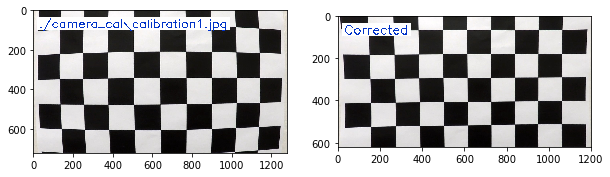

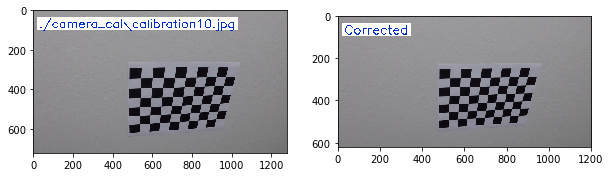

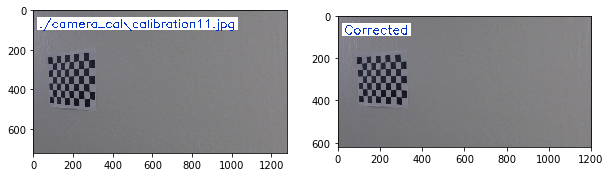

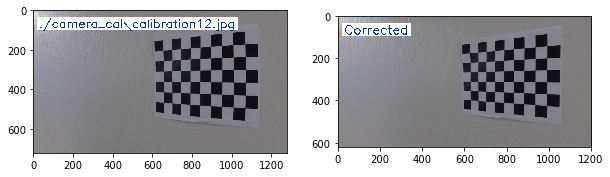

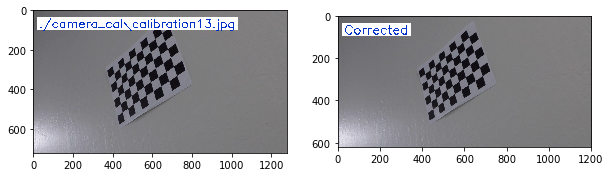

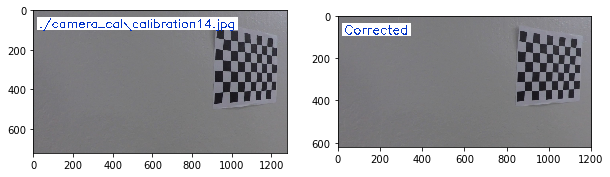

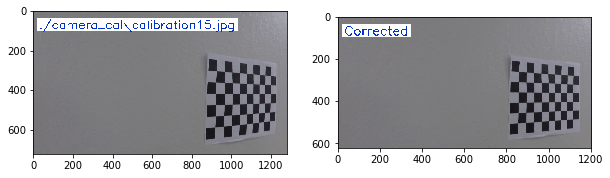

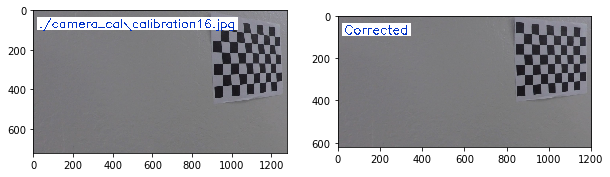

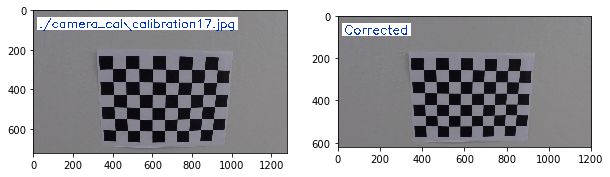

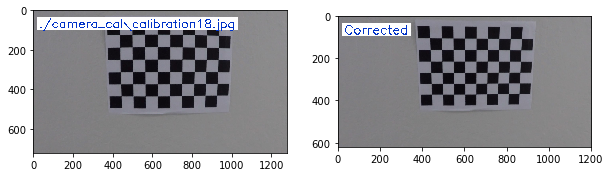

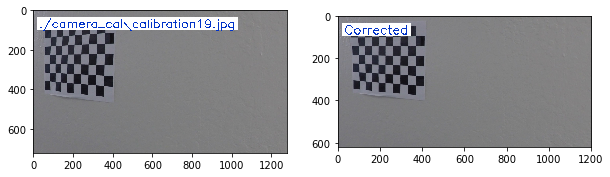

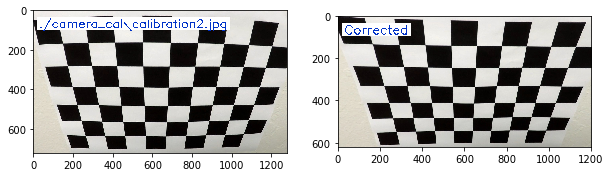

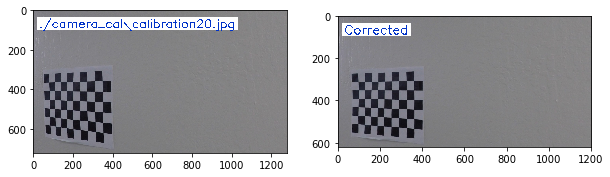

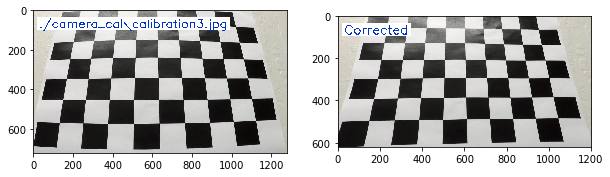

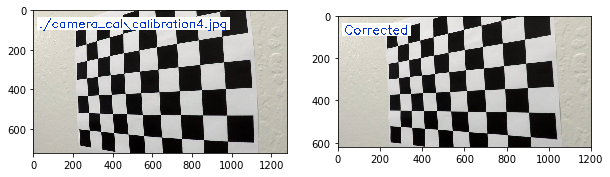

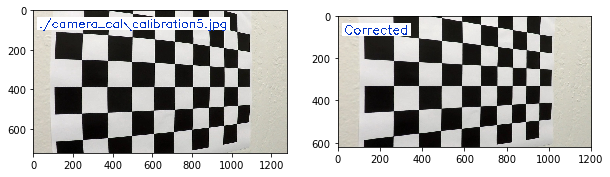

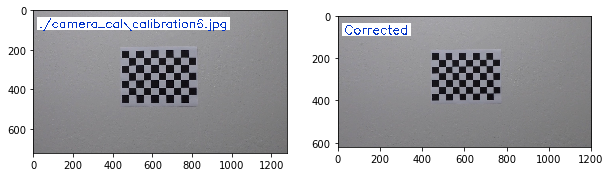

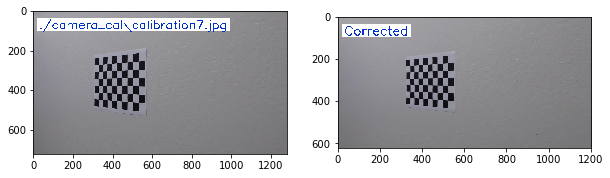

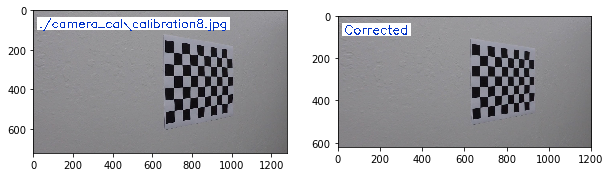

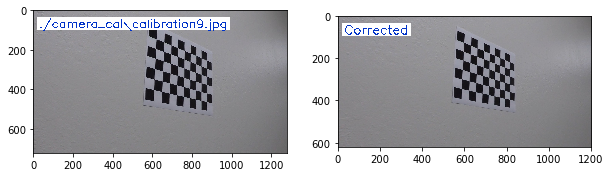

In [3]:
import glob

for img_n in glob.glob('./camera_cal/*.jpg'):
    cal_image = plt.imread(img_n)
    
    plt.figure(figsize=(10,8))
    
    plt.subplot(1,2,1)
    plt.imshow(add_image_label(cal_image, img_n))

    plt.subplot(1,2,2)
    plt.imshow(add_image_label(camera.undistort(cal_image), 'Corrected'))
    plt.show()

## Image preprocessing
### Implementation
To generate a binary image with all the relevant features for lane detection the following techniques are used:
- S-channel (HLS): Threshold of sobel operator in x direction
- S-channel (HLS): Threshold of sobel operator magnitude combined with Sobel gradient direction (
- White detection in HSV with threshold
- Yellow detection in HSV with threshold

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

class ImagePreprocessor(object):
    def __init__(self):
        self._binary = {}

    def _sobel_abs(self, image, axis='x', thresh=(100, 255)): 
        ''' Threshold of absolute sobel on S-channel along axis'''
        hls_img = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        S = hls_img[:,:,2]
        
        if axis == 'x':
            sobel = cv2.Sobel(S, cv2.CV_64F, 1, 0)
        elif axis == 'y':
            sobel = cv2.Sobel(S, cv2.CV_64F, 0, 1)
        
        abs_sobel = np.absolute(sobel)
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        
        binary = np.zeros_like(scaled_sobel)
        binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
        return binary
    
    def _sobel_mag(self, image, thresh=(100, 255)):
        ''' Threshold of sobel magniute on S-channel '''
        hls_img = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        S = hls_img[:,:,2]
        
        sobelx = cv2.Sobel(S, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(S, cv2.CV_64F, 0, 1, ksize=3)

        sobel_mag = np.sqrt(sobelx**2 + sobely**2)
        
        scaled_mag = np.uint8(255*sobel_mag/np.max(sobel_mag))

        binary = np.zeros_like(scaled_mag)
        binary[(scaled_mag >= thresh[0]) & (scaled_mag <= thresh[1])] = 1

        return binary

    def _grad_dir(self, image, thresh=(0, np.pi/2)):
        ''' Threshold on gradient of sobel on S-channel '''
        hls_img = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
        S = hls_img[:,:,2]

        sobelx = cv2.Sobel(S, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(S, cv2.CV_64F, 0, 1, ksize=3)

        grad_dir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary = np.zeros_like(grad_dir)
        binary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1

        return binary    
 

    def _hsv_color(self, image, thresh=([0,0,0],[255,255,255])):
        ''' Color threshold in HSV space'''
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        H = hsv[:,:,0]
        S = hsv[:,:,1]
        V = hsv[:,:,2]
                   
        low, high = thresh

        binary = np.zeros_like(H)
        binary[(H >= low[0]) & (H <= high[0]) & \
               (S >= low[1]) & (S <= high[1]) & \
               (V >= low[2]) & (V <= high[2])] = 1
        
        return binary
    
    def plot(self):
        ''' Plot the binary mask created with last process() call '''
        plt.figure(figsize=(20,10))
        for i,key in enumerate(self._binary):
            plt.subplot(2, np.ceil(len(self._binary)/2), i+1)
            image = 255 * self._binary[key]
            image = add_image_label(image, key)
            plt.imshow(image, cmap='gray')
        plt.show()
    
    def process(self, image):
        ''' Process an image and create a consolidated binary mask '''
        self._binary = {}
        binary = self._binary
                   
        thresh_hsv_yellow = ([80,80,150],[120,255,255])
        thresh_hsv_white = ([0,0,200],[255,30,255])
      
        binary['sobelx'] = self._sobel_abs(image, axis='x', thresh=(50,255))
        binary['sobelmag'] = self._sobel_mag(image, thresh=(60,255))
        binary['graddir'] = self._grad_dir(image, thresh=(0.7,1.3))
        binary['yellow'] = self._hsv_color(image, thresh=thresh_hsv_yellow)
        binary['white'] = self._hsv_color(image, thresh=thresh_hsv_white)

        final = np.zeros_like(image[:,:,0])
        final[(binary['sobelx'] == 1) | (binary['yellow'] == 1) | (binary['white'] == 1) | \
              ((binary['sobelmag'] == 1) & (binary['graddir'] == 1))] = 1
        binary['final'] = final
        return binary['final']
        
img_pp = ImagePreprocessor()

### Verification
For verification the method plot was added to the class. This method plots all binary and the final consolidated masks. Thresholds of the algorithms were adapted with these images.

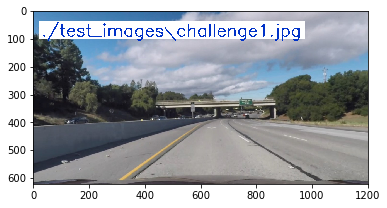

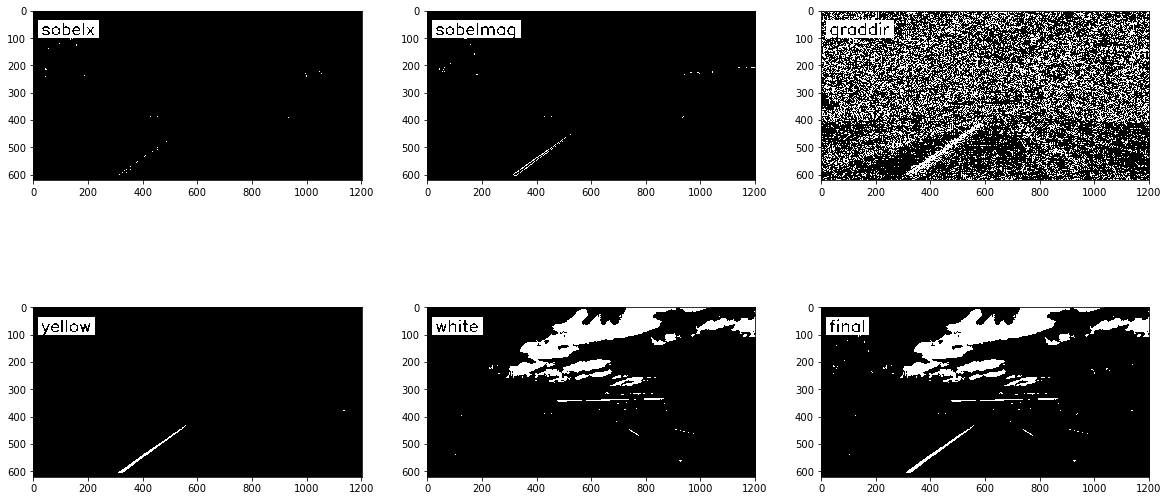

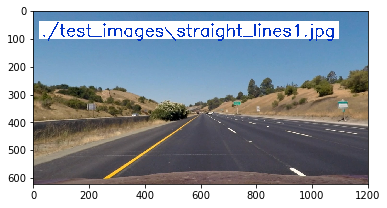

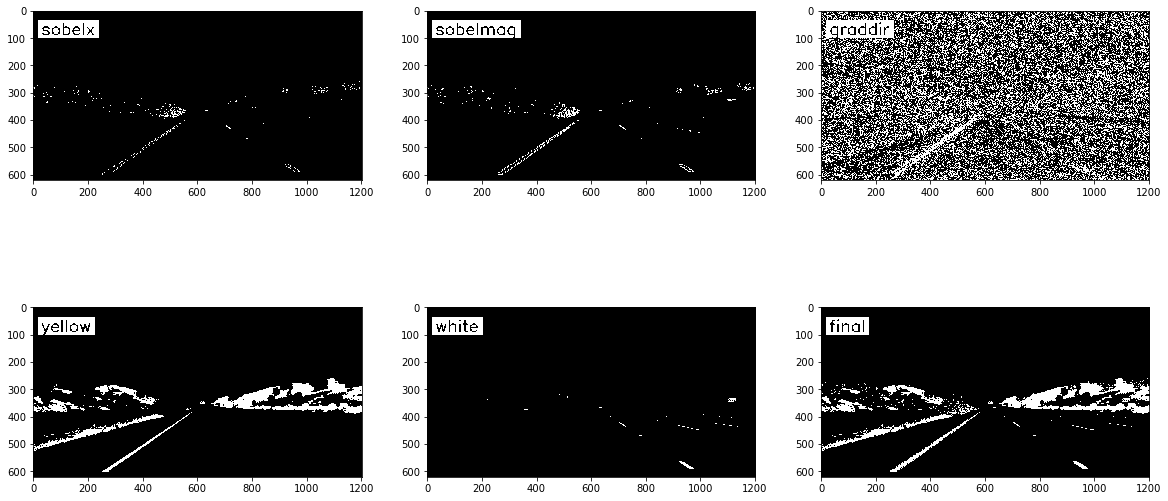

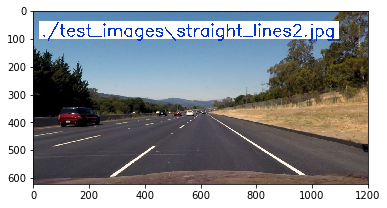

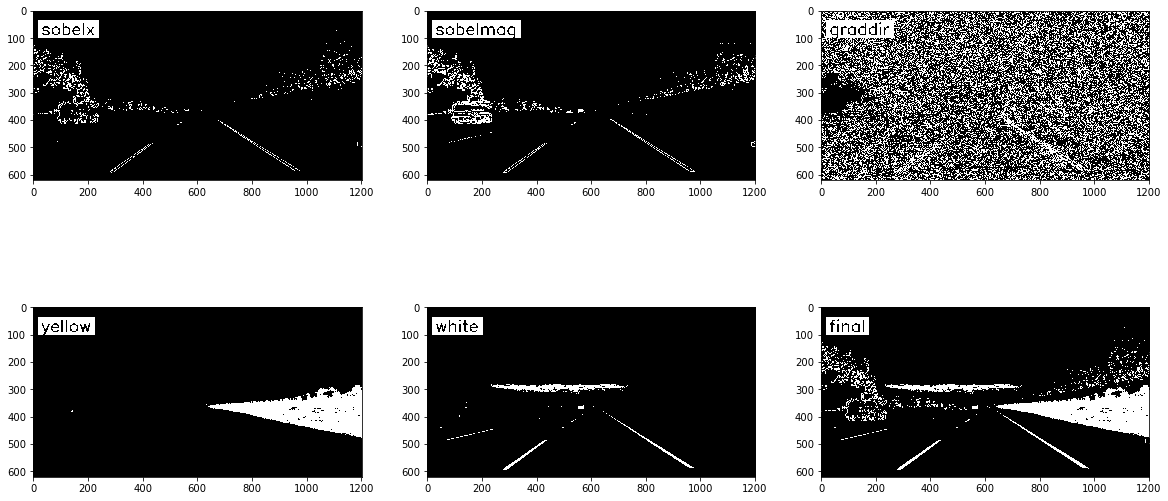

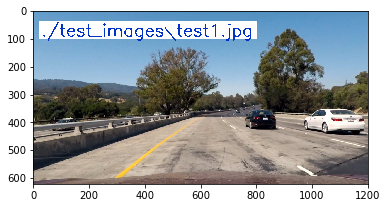

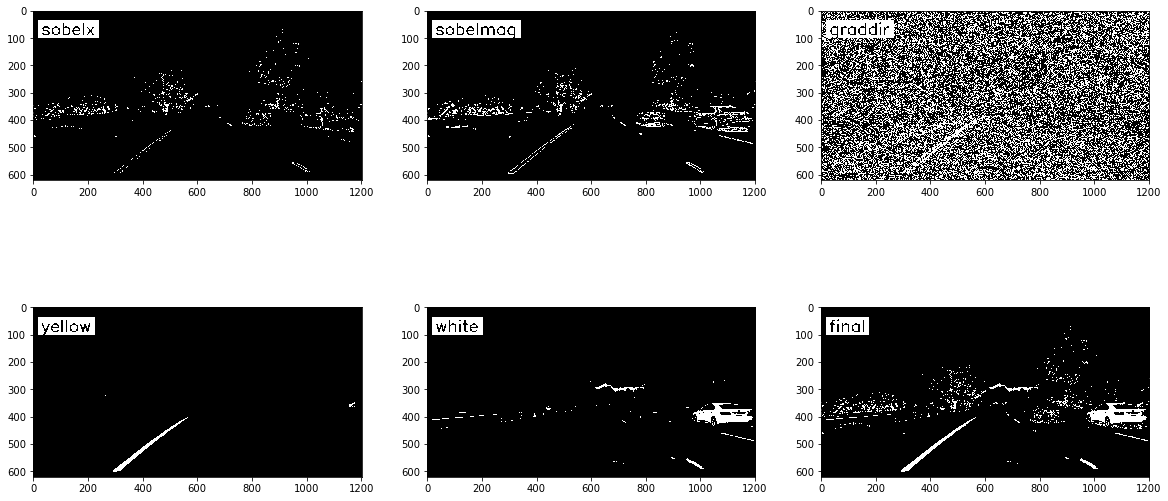

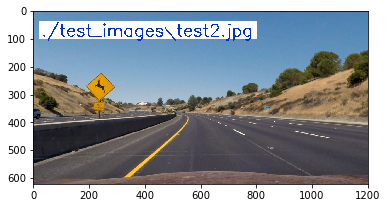

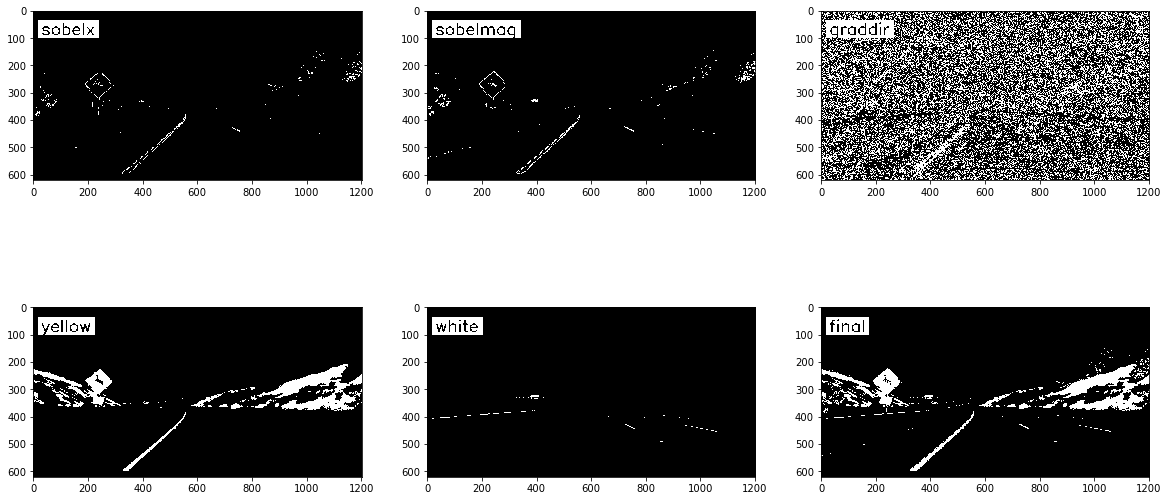

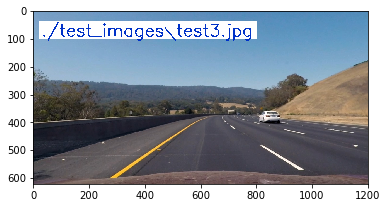

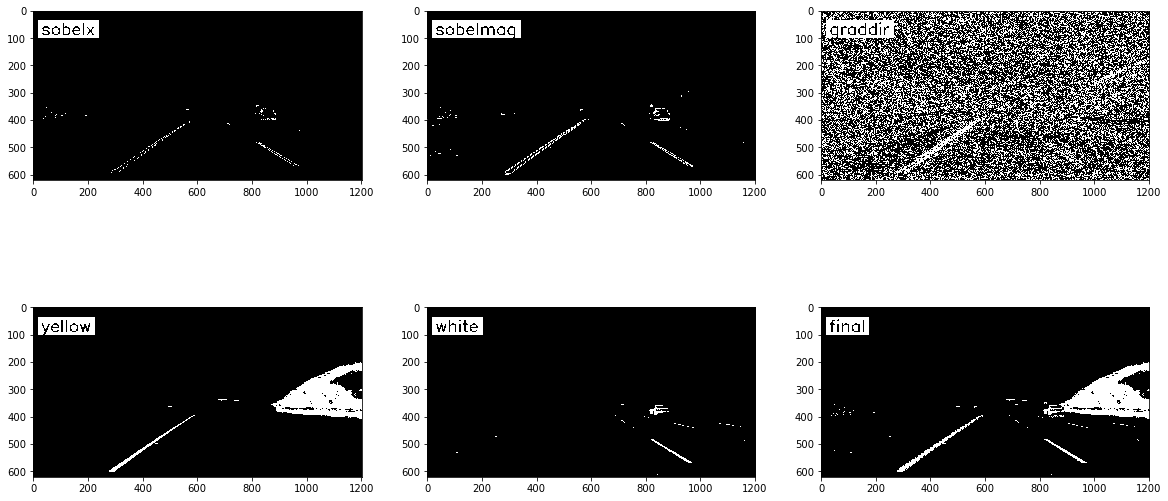

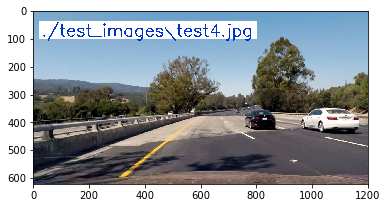

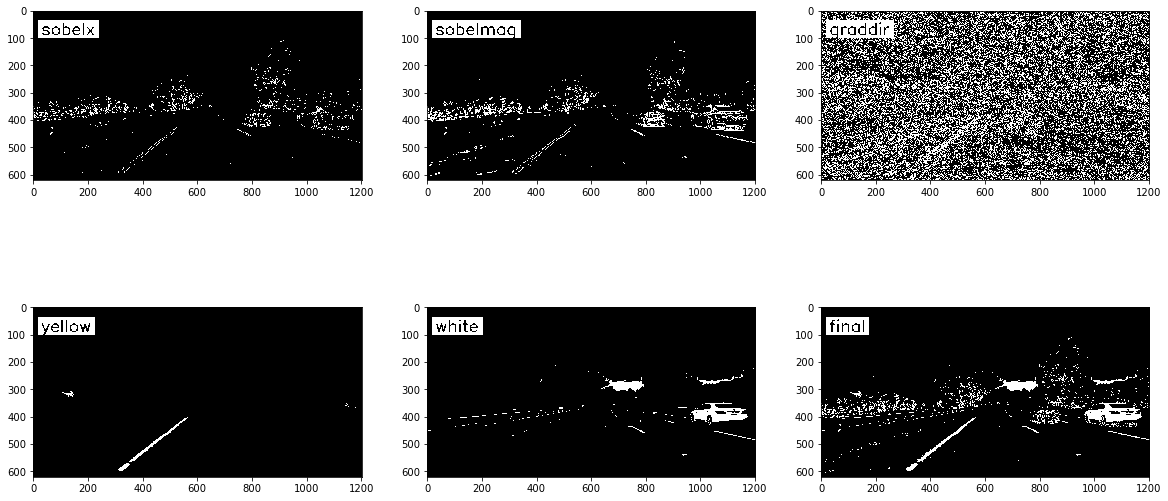

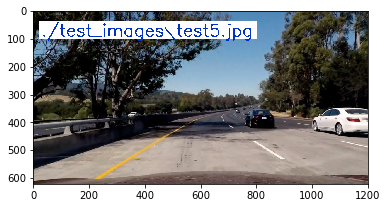

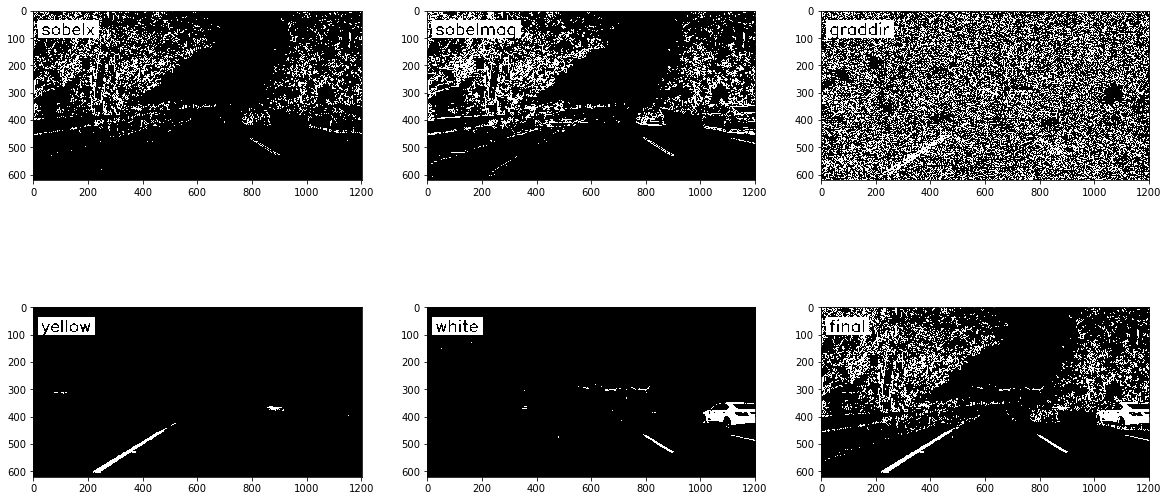

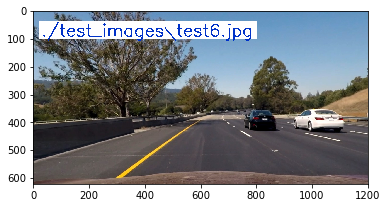

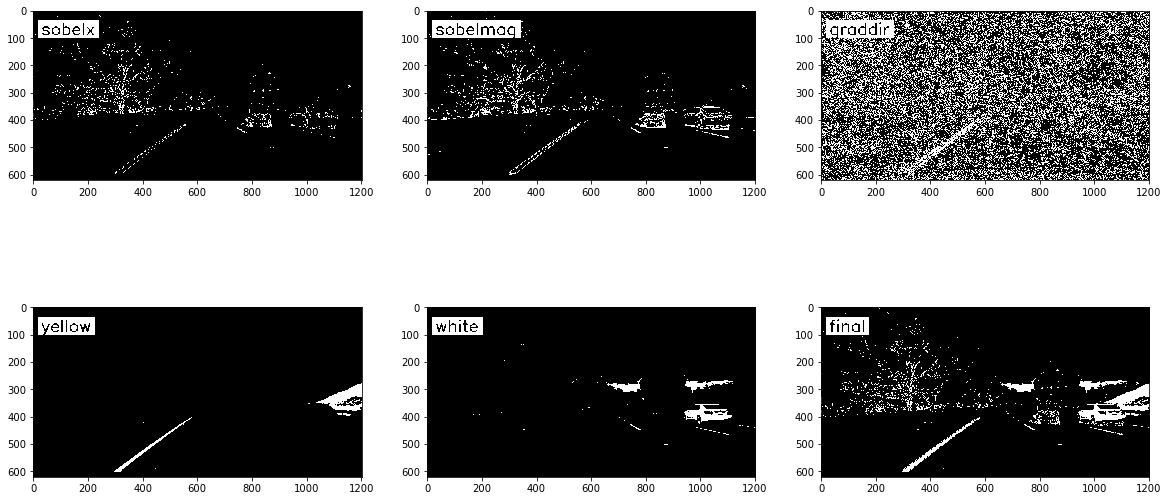

In [6]:
import glob

for img_n in glob.glob('./test_images/*.jpg'):
    test_image = camera.undistort(plt.imread(img_n))
    img_pp.process(test_image)
    
    plt.imshow(add_image_label(test_image, img_n))
    plt.show()
    img_pp.plot()    

## Image transformation
### Implementation
The transformation to birds eye view is implemented as class with transform() and inv_transform() operations. Initializing the class sets the internal state to the default transformation operation via init_transform(). The transformation points for the default transformation operation were determined empirically (see verification images).

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class ImageTransformer(object):
    def __init__(self):
        self.init_transform()

    def init_transform(self, x=[297, 543, 691, 949], y=[580, 410], x_scale=1.8):
        ''' Initialize the class with the default transformation '''
        x_center = np.mean(x)
        xs = [x_center - (x_center - x[0]) * x_scale,
              x_center - (x_center - x[1]) * x_scale,
              x_center + (x[2] - x_center) * x_scale,
              x_center + (x[3] - x_center) * x_scale]
        xi = [int(x) for x in xs]
        
        src = np.float32([[xi[0],y[0]], [xi[1],y[1]], [xi[2],y[1]], [xi[3],y[0]]])
        dst = np.float32([[0,600], [0,0], [600,0], [600,600]])
        self._M = cv2.getPerspectiveTransform(src, dst)
        self._Minv = cv2.getPerspectiveTransform(dst, src)
 
    def transform(self, image, size=(600,600)):
        ''' Transform an image to a warped image of determined size '''
        img_warp = cv2.warpPerspective(image, self._M, size, flags=cv2.INTER_LINEAR)
        return img_warp
    
    def inv_transform(self, image, size=(600,600)):
        ''' Inverse transform of warped image to normal view'''
        img_unwarped = cv2.warpPerspective(image, self._Minv, size, flags=cv2.INTER_LINEAR)
        return img_unwarped

img_tf = ImageTransformer()

### Verification
Calibration of transformation was done on provided example images with straight lines. The vertical lines in the warped image are used to empirically determine the transformation points. Since the straight lines are not perfectly straight a compromise between both provided straigh lane images was done to fit both as best as possible.

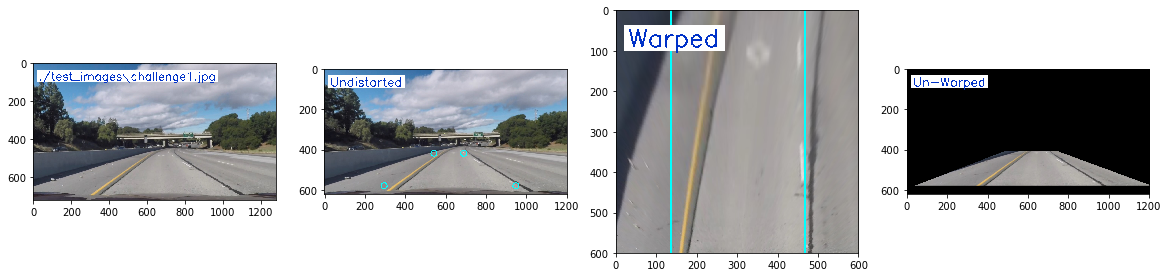

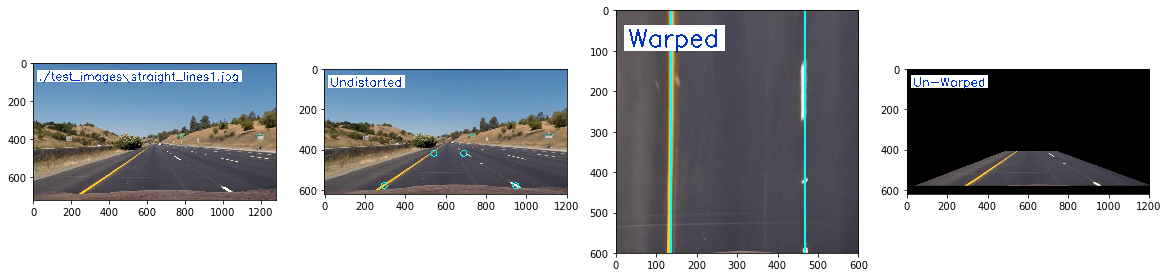

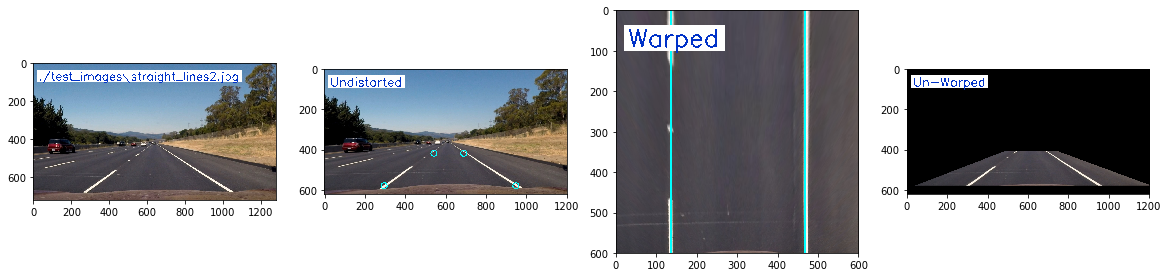

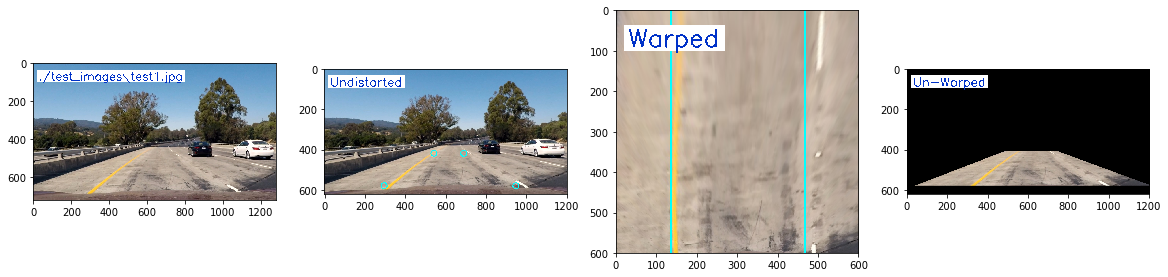

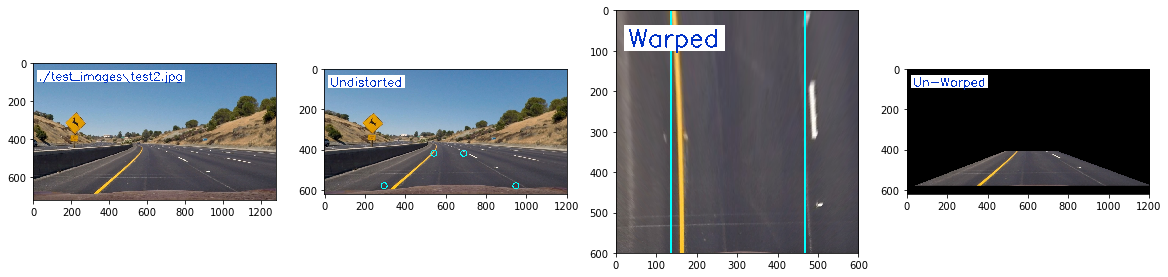

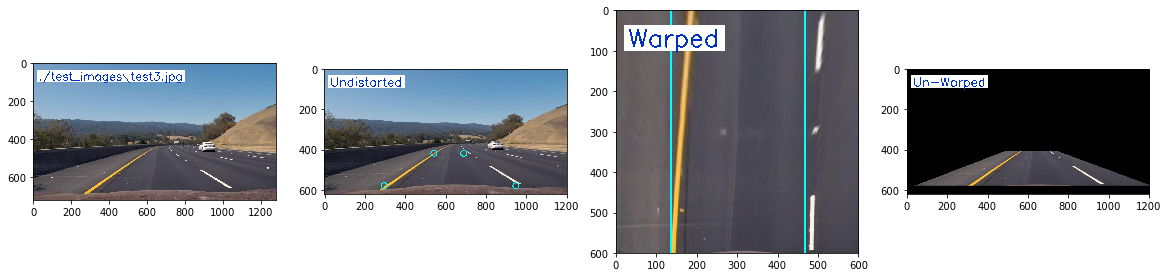

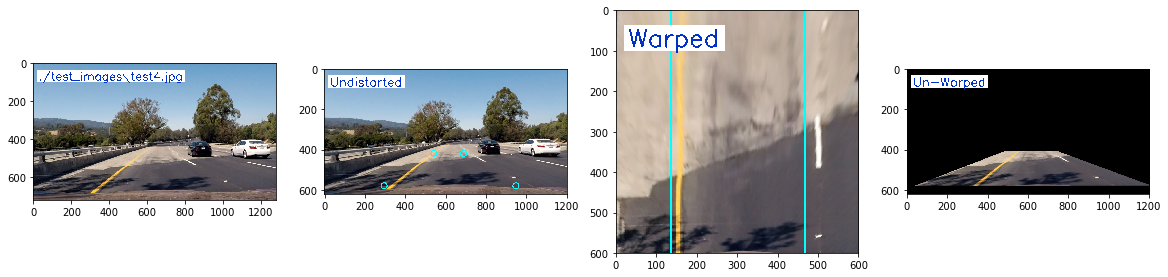

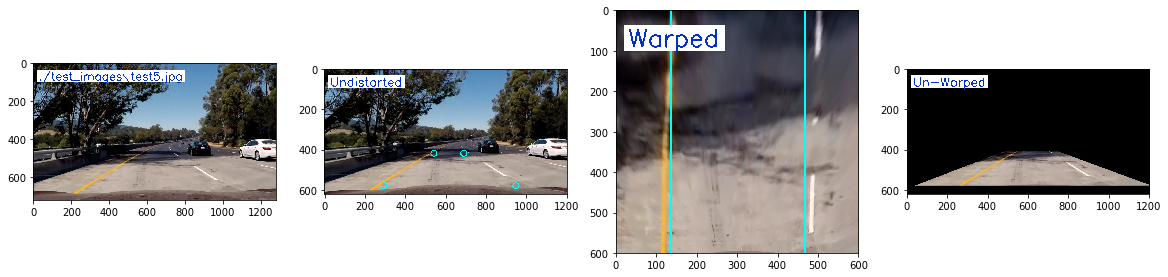

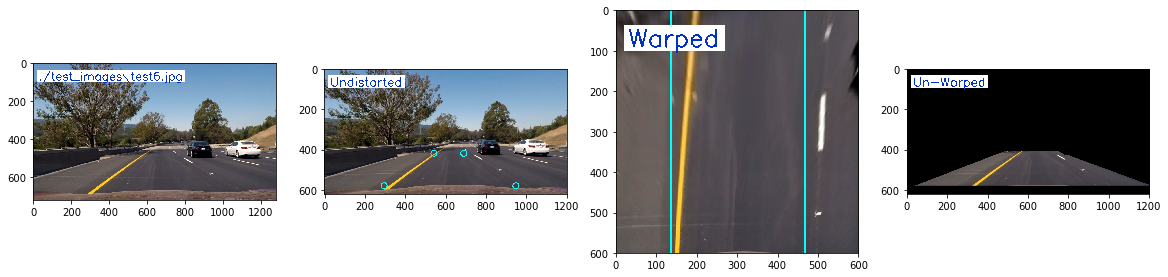

In [8]:
import glob

for img_n in glob.glob('./test_images/*.jpg'):
    test_image = plt.imread(img_n)
    img_undistorted = camera.undistort(test_image)
    img_transform = img_tf.transform(img_undistorted)
    img_invtransform = img_tf.inv_transform(img_transform, size=(img_undistorted.shape[1], img_undistorted.shape[0]))
    
    plt.figure(figsize=(20,5))
    
    plt.subplot(1,4,1)
    plt.imshow(add_image_label(test_image, img_n))
    
    for p in [(297,580), (543,420), (691,420), (949, 580)]:
        cv2.circle(img_undistorted, p, 15, color=(0, 255, 255), thickness=3)
    plt.subplot(1,4,2) 
    plt.imshow(add_image_label(img_undistorted, 'Undistorted'))

    cv2.line(img_transform, (135,600), (135,0), color=(0, 255, 255), thickness=3)
    cv2.line(img_transform, (465,600), (465,0), color=(0, 255, 255), thickness=3)
    plt.subplot(1,4,3)
    plt.imshow(add_image_label(img_transform, 'Warped'))
 
    plt.subplot(1,4,4)
    plt.imshow(add_image_label(img_invtransform, 'Un-Warped'))    
    plt.show()

## Lane finding
### Implementation
Lane finding is implemented in several classes:
- PT1Filer: simple filter for the poly coefficients of the lanes
- Lane: representation of a lane
- LaneFinder: search and track lanes in a sequence of images

### Lane objects
The lane is represented by poly coefficents up to 2nd order. The coefficients are determined from a binary image and filtered from the previous coefficients with the update function. The centroids form LaneFinder have to be provided to mask the binaries representing the lanes.
A method to calculate the curvature is included: https://en.wikipedia.org/wiki/Radius_of_curvature

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class PT1Filter(object):
    ''' Simple PT1 Filter implementation '''
    def __init__(self, k):
        self._state = None
        self._k = k
        
    def init(self):
        self._state = None
        
    def filter(self, value):
        if self._state is not None:
            self._state = self._state + self._k * (value - self._state)
        else:
            self._state = value
        return self._state

class Lane(object):
    ''' Lane object represented with poly coefficients'''
    def __init__(self):
        self._poly_coeff = None
        self._filter = [PT1Filter(0.1), PT1Filter(0.1), PT1Filter(0.1)]
        
    def set(self, lane_poly):
        self._poly_coeff = lane_poly
    
    def _poly_from_binary(self, binary, centroids, offset=50):
        ''' Obtain poly coefficients from binary image and centroids '''
        masked_binary = np.copy(binary)
        split_binary = np.array_split(masked_binary, len(centroids), axis=0)
        x_value = np.array([None] * binary.shape[1])

        for i in range(len(centroids)):
            if centroids[i]:
                lower_index = max(0, centroids[i] - offset)
                upper_index = min(binary.shape[1], centroids[i] + offset)

                split_binary[i][:,0:lower_index] = 0
                split_binary[i][:,upper_index:-1] = 0
            else:
                split_binary[i][:,:] = 0

        for yindex in range(binary.shape[1]):
            x = np.array([i if m != 0 else None for i,m in enumerate(masked_binary[yindex,:])])
            if np.any(x):
                x_value[yindex] = np.mean(x[np.not_equal(x, None)])

        y_value = np.linspace(0, binary.shape[1]-1, num=binary.shape[1])
        weights = np.linspace(1, 0.6, num=binary.shape[1])
        valid_index = np.not_equal(x_value, None)

        try:
            poly = np.polyfit(y_value[valid_index], x_value[valid_index], 2, w=weights[valid_index])
        except:
            print(y_value[valid_index])
            print(x_value[valid_index])
            raise Exception('Error fitting poly')
        return poly
     
    def update(self, binary, centroids):
        ''' Update the lane with new binary image and centroids '''
        poly = self._poly_from_binary(binary, centroids)
        poly_filter = [self._filter[i].filter(c) for i,c in enumerate(poly)]
        self._poly_coeff = poly_filter
        return self._poly_coeff
        
    def get(self, y):
        ''' Get x from y value calculate from poly coefficients '''
        x = self._poly_coeff[0]*y**2 + self._poly_coeff[1]*y + self._poly_coeff[2]
        return x    
        
    def curvature(self, y=300, scalex=1, scaley=1):
        ''' Calculate the curvature at point y from the poly coefficients.
            Scale factors can be used to obtain a physical curvature (m/pixel) '''
        # Scaled Polynomial:
        # x = poly_coeff[0]*y^2 + poly_coeff[1]*y + poly_coeff[0]
        # scaled: ys = y * scaley, xs = x * scalex
        # xs = scalex * [(poly_coeff[0] / scaley^2) * ys^2 + (poly_coeff[1] / scaley) * ys + poly_coeff[0]]
        # xs = a * ys^2 + b * ys2 + c
        a = self._poly_coeff[0] * scalex / scaley**2
        b = self._poly_coeff[1] * scalex / scaley
        c = self._poly_coeff[2] * scalex
        ys = y * scaley
        
        # Curvature:
        # R = [(1 + (x')^2)^(3/2)] / [(x'')]
        # x' = dx/dy = 2a * ys + b
        # x'' = d^2x/dy^2 = 2a
        dx = 2*a * ys + b
        dx2 = 2*a
        R = abs( ((1 + dx**2)**(3/2)) / (dx2) )        
        return R


### Lane Finder
The Lane Finder class searches the left and right lane in a sequence of image. The image is divided into several segments along the y axis. In these segements a window is convoluted to find possible lane features. The lanes are determined by a stateful search consisting of:
- \_search\_maxima\_new(): No previous knowledge of lane position in layer. Search starts from center outwards till a threshold in the convoluted function is exceeded.
- \_search\_maxima\_pos(): Search lane position around previously known position. Used to search lane segment based on position of previous lane segment.
- \_search\_maxima\_poly(): Search lane position around previously found lane. Used to serach lane segment based on lane found in previous image.

In [10]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

class LaneFinder(object):
    def __init__(self, num_layer=12):
        self._num_layer = num_layer
        self.init()
    
    def init(self):
        self._last_lane = {'left':None, 'right':None}
    
    def _get_slice(self, binary, level):
        ''' Get an image slice specified by level, total number of
            levels is defined self._num_layer '''
        return np.array_split(binary, self._num_layer, axis=0)[level]
      
    def _convolve(self, function, window_width=30):
        ''' Convolve a function with a rectangle window with window_width '''
        window = np.ones(window_width)
        return np.convolve(window, function)
    
    def _search_maxima(self, function, level, lane):
        ''' search maxima in function. Based on internal state
            either a new search, search based on previous position
            or search on previous lane is used '''
        y_center = function.shape[0] / self._num_layer * (level+0.5)
        
        if self._last_lane[lane]:
            center = self._search_maxima_poly(function, y_center, lane)
        elif self._last_center[lane]:
            center = self._search_maxima_pos(function, lane)
        else:
            center = self._search_maxima_new(function, lane) 

        return center
    
    def _search_maxima_new(self, function, lane, threshold=50):
        ''' Based on lane a maxima is searched in left or right
            half of the function '''
        split_function = np.array_split(function, 2)
        if lane == 'left':
            sub_function = split_function[0][0:-50]
            offset = 0
            sub_function_reversed = sub_function[::-1]
            max_pos_reversed = np.argmax(sub_function_reversed > threshold)
            max_pos = sub_function.shape[0] - max_pos_reversed - 1
        elif lane == 'right':
            sub_function = split_function[1][50:-1]
            offset = split_function[0].shape[0]+50
            max_pos = np.argmax(sub_function > threshold)
        else:
            raise('Error: unexpected lane argument')
        
        if sub_function[max_pos] > threshold:
            position = max_pos + offset
            self._last_center[lane] = position
            return position
        else:
            return None            
    
    def _search_maxima_pos(self, function, lane, offset=30, threshold=50):
        ''' Based on previous position a maxima is searched with 
            the offset around it '''
        xmax = function.shape[0]
        lower_index = max(0, min(xmax-50, self._last_center[lane]-offset))
        upper_index = min(xmax, max(50, self._last_center[lane]+offset))
        sub_function = function[lower_index:upper_index]
        
        max_pos = np.argmax(sub_function)
        if sub_function[max_pos] > threshold:
            position = max_pos + lower_index
            self._last_center[lane] = position
            return position
        else:
            return None
    
    def _search_maxima_poly(self, function, ycenter, lane, offset=30, threshold=50):
        ''' Based on previous lane poly a maxima is searched with
            the offset around the x position '''
        xcenter = int(self._last_lane[lane].get(ycenter))
        xmax = function.shape[0]
        lower_index = max(0, min(xmax-50, xcenter-offset))
        upper_index = min(xmax, max(50, xcenter+offset))
        sub_function = function[lower_index:upper_index]

        max_pos = np.argmax(sub_function)
        if sub_function[max_pos] > threshold:
            position = max_pos + lower_index
            return position
        else:
            return None
    
    def _search_lane_centroids(self, binary):
        ''' Search the lane centroids for all levels in the 
            binary image '''
        self._last_center = {'left':None, 'right':None}
        centroids = {'left':[None]*self._num_layer, 'right':[None]*self._num_layer}
        
        for i in range(self._num_layer):
            binary_line = np.sum(self._get_slice(binary, i), axis=0)
            convo = self._convolve(binary_line)
            centroids['left'][i] = self._search_maxima(convo, i, lane='left')
            centroids['right'][i] = self._search_maxima(convo, i, lane='right')
        return centroids
 
    def _fit_lanepoly(self, binary, centroids, lane):
        ''' Fits a lane poly and updates the lane from the
            binary image and the already searched centroids '''
        if not self._last_lane[lane]:
            self._last_lane[lane] = Lane()
        self._last_lane[lane].update(binary, centroids)
        return self._last_lane[lane]

    def find_lanes(self, binary):
        ''' Find lanes in the binary image '''
        binary_flipped = np.flipud(binary)
        centroids = self._search_lane_centroids(binary_flipped)
        lanes = []
        for l in ['left', 'right']:
            if any([c != None for c in centroids[l]]):
                lane = self._fit_lanepoly(binary_flipped, centroids[l], lane=l)
            else:
                lane = self._last_lane[l]
            lanes.append(lane)
        return tuple(lanes)
    
lane_finder = LaneFinder()

### Verification
The LaneFinder is verified on all provided test images. To verify the stateful search find_lanes() is called twice. Some of the images from the challenge videos can not be identified correctly from a single image due to several artefacts in the binary.

Curvature Left: 189.96
Curvature Right: 165.11


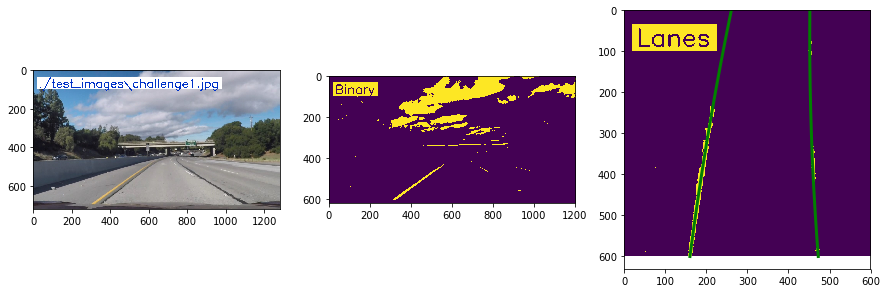

Curvature Left: 379.85
Curvature Right: 406.34


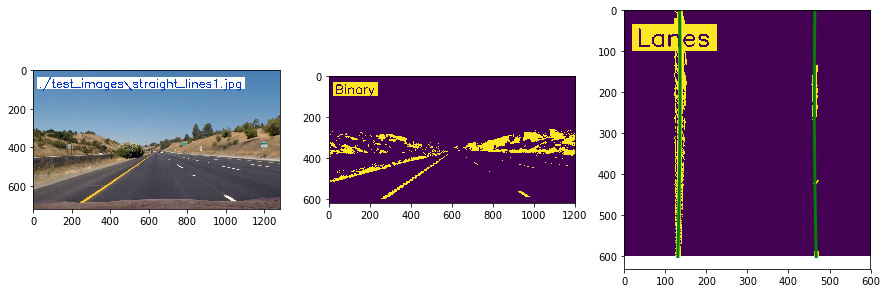

Curvature Left: 843.05
Curvature Right: 1534.87


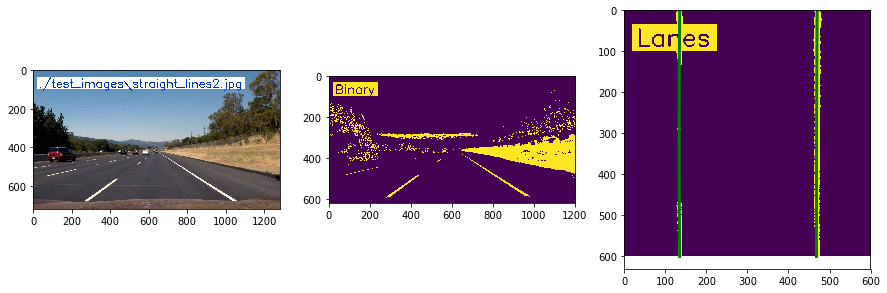

Curvature Left: 168.37
Curvature Right: 580.50


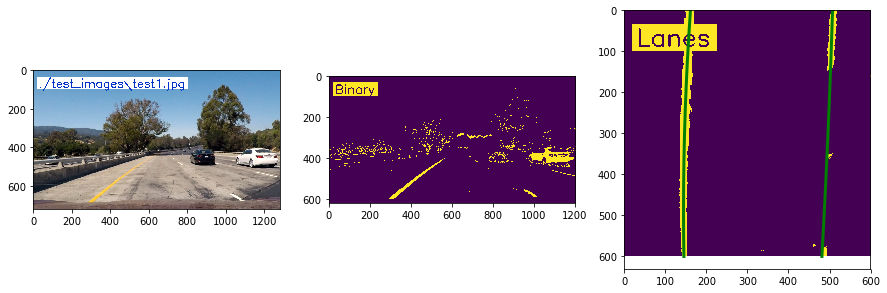

Curvature Left: 257.03
Curvature Right: 322.19


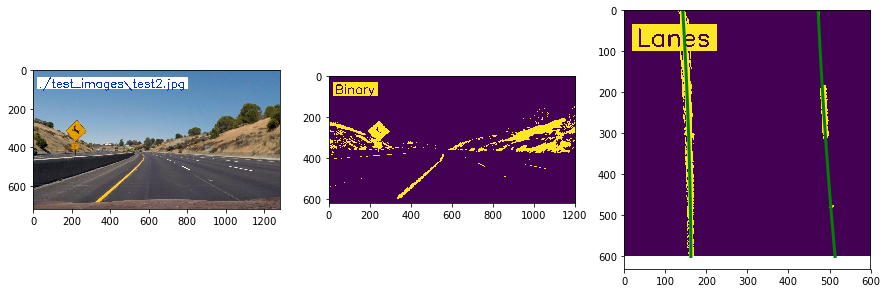

Curvature Left: 343.95
Curvature Right: 208.49


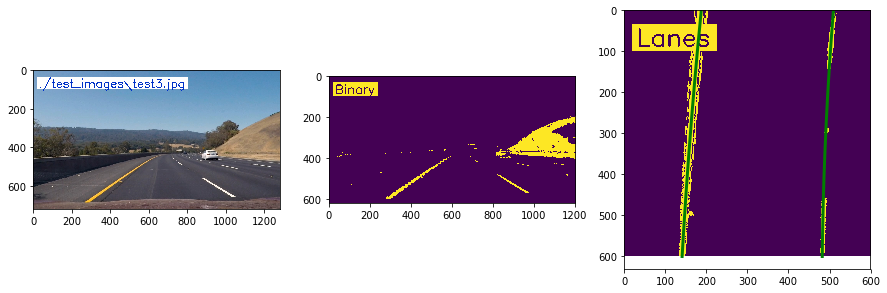

Curvature Left: 608.14
Curvature Right: 84.61


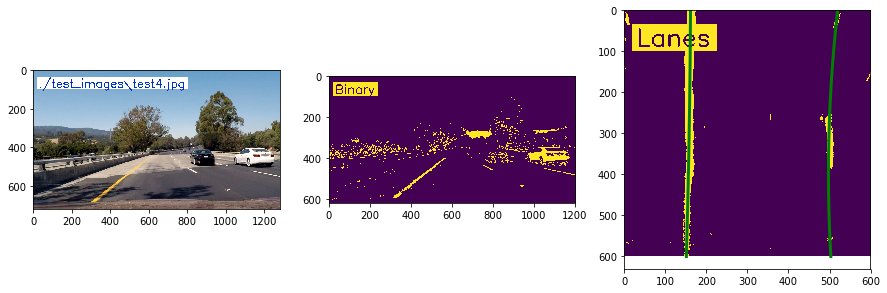

Curvature Left: 802.30
Curvature Right: 315.97


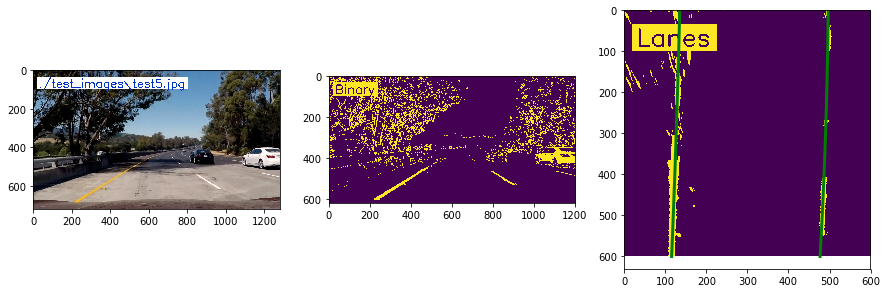

Curvature Left: 201.17
Curvature Right: 23.08


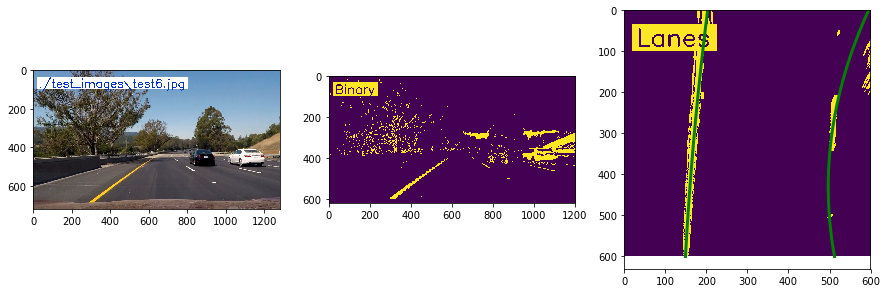

In [11]:
import glob

for img_n in glob.glob('./test_images/*.jpg'):
    test_image = plt.imread(img_n)
    
    img1 = camera.undistort(test_image)
    img2 = img_pp.process(img1)
    img3 = img_tf.transform(img2)

    lane_finder.init()
    left, right = lane_finder.find_lanes(img3)
    left, right = lane_finder.find_lanes(img3)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(add_image_label(test_image, img_n))
    
    plt.subplot(1,3,2)
    plt.imshow(add_image_label(img2*255, 'Binary'))
    
    plt.subplot(1,3,3)
    plt.imshow(add_image_label(img3*255, 'Lanes'))
    
    ploty=np.linspace(0,600,599)
    left_fitx = [left.get(600-y) for y in ploty]
    right_fitx = [right.get(600-y) for y in ploty]
    plt.plot(left_fitx, ploty, color='green', linewidth=3)
    plt.plot(right_fitx, ploty, color='green', linewidth=3)
    
    scalex = 5/300
    scaley = 3/150
    print('Curvature Left: %.2f' % left.curvature(y=300, scalex=scalex, scaley=scaley))
    print('Curvature Right: %.2f' % right.curvature(y=300, scalex=scalex, scaley=scaley))
    plt.show()

## Pipeline
### Implementation
The provided video is processed by the pipeline of all previously implemented classes. The lane is highlighted and annotation for curvature and off center position is added. Scaling for these is determined from the warped images and typicall lane width and marking lengths.
https://en.wikipedia.org/wiki/Lane

In [12]:
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
%matplotlib inline

class Pipeline(object):
    def __init__(self):
        self._camera = Camera()
        self._camera.calibrate()
        self._img_pp = ImagePreprocessor()
        self._img_tf = ImageTransformer()
        self._lane_finder = LaneFinder()
        self._scalex=3/300
        self._scaley=5/150
    
    def _init_video(self):
        ''' Call before processing a new video to reset the internal states '''
        self._lane_finder.init()
      
    def _curvature_phys(self, lanes, y=300):
        ''' Calculate the physical curvature of the lane '''
        curv_l = lanes[0].curvature(y=y, scalex=self._scalex, scaley=self._scaley)
        curv_r = lanes[1].curvature(y=y, scalex=self._scalex, scaley=self._scaley)
        return (curv_l + curv_r) / 2
    
    def _off_center_phys(self, lanes, center=300):
        ''' Calculate the off center position of the vehicle '''
        off_l = (center - lanes[0]._poly_coeff[2]) * self._scalex
        off_r = (center - lanes[1]._poly_coeff[2]) * self._scalex
        return (off_l + off_r) / 2
    
    def _annotate(self, image, lanes):
        ''' Annotate image with curvature and off center position '''
        img_ann = np.copy(image)
        curv = self._curvature_phys(lanes)
        off = self._off_center_phys(lanes)
        
        label_curv = 'Curvature: %.1f m' % curv
        img_ann = cv2.putText(img_ann, label_curv, (30,40), 0, 1, (0,0,0), 2, cv2.LINE_AA)
        label_off = 'Center offset: %.1f m' % off
        img_ann = cv2.putText(img_ann, label_off, (30,70), 0, 1, (0,0,0), 2, cv2.LINE_AA)
        
        return img_ann
    
    def _draw_lane(self, image):
        ''' Run pipeline and draw lane on image '''
        img_undistorted = self._camera.undistort(image)
        img_binary = self._img_pp.process(img_undistorted)
        img_warped = self._img_tf.transform(img_binary)
        left,right = self._lane_finder.find_lanes(img_warped)

        img_blank_warped = self._img_tf.transform(img_undistorted)

        ploty=np.linspace(0,img_blank_warped.shape[0])
        if left:
            left_fitx = [left.get(img_blank_warped.shape[0]-y) for y in ploty]
        else:
            left_fix = [0 for y in ploty]
            
        if right:
            right_fitx = [right.get(img_blank_warped.shape[0]-y) for y in ploty]  
        else:
            right_fitx = [img_blank_warped.shape[0] for y in ploty]

        points_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        points_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        points = np.hstack((points_left, points_right))

        img_lane_warped = cv2.fillPoly(img_blank_warped, np.int_([points]), (0,255, 0))

        img_lane = self._img_tf.inv_transform(img_lane_warped, size=(img_undistorted.shape[1],img_undistorted.shape[0]))

        img_lane_ov = cv2.addWeighted(img_undistorted, 1, img_lane, 0.3, 0)          
        img_lane_ov = cv2.resize(img_lane_ov, (image.shape[1], image.shape[0]), interpolation = cv2.INTER_CUBIC)
        
        img_ann = self._annotate(img_lane_ov, (left,right))
        
        return img_ann
    
    def process_video(self, video_input, video_output):
        ''' Process a video '''
        self._init_video()
        
        clip = VideoFileClip(video_input)
        lane_clip = clip.fl_image(self._draw_lane)
        lane_clip.write_videofile(video_output, audio=False)
        
pipe = Pipeline()

Could not find corners for ./camera_cal\calibration1.jpg
Could not find corners for ./camera_cal\calibration4.jpg
Could not find corners for ./camera_cal\calibration5.jpg


### Verification
The pipeline class is verified with the provided test images.

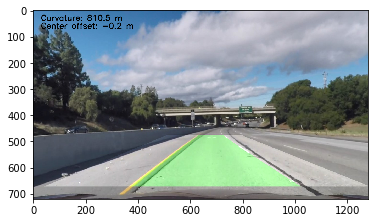

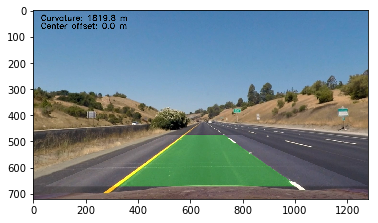

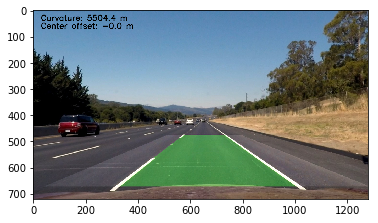

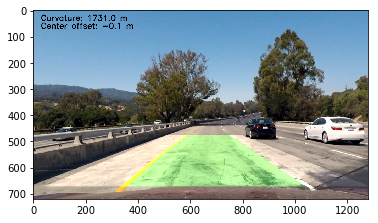

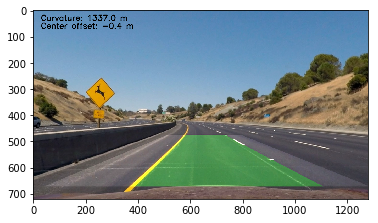

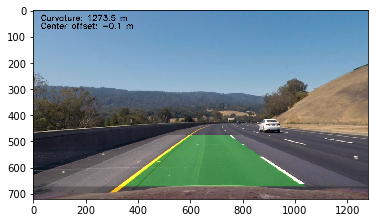

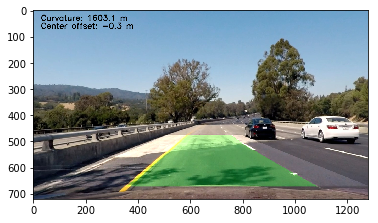

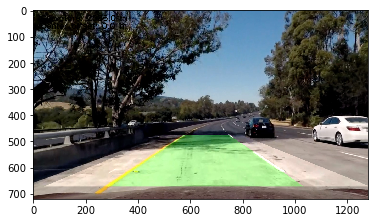

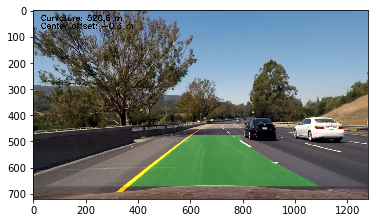

In [13]:
for img_n in glob.glob('./test_images/*.jpg'):
    test_image = plt.imread(img_n)
    
    pipe._init_video()
    lane_image = pipe._draw_lane(test_image)
    plt.imshow(lane_image)
    plt.show() 

## Validation
### Video 1
Running the pipeline the first video shows good results.

In [20]:
pipe.process_video('./project_video.mp4', './project_video_lane.mp4')

[MoviePy] >>>> Building video ./project_video_lane.mp4
[MoviePy] Writing video ./project_video_lane.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [31:06<00:01,  1.47s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_lane.mp4 



In [21]:
from IPython.display import HTML
HTML("""
<video width="480" height="360" controls>
  <source src="project_video_lane.mp4" type="video/mp4">
</video>
""")

### Video 2
The second video was more challenging since several lane candidates appear in the video. I had to change the image processing to work with different color channels to cope with the shadow present in the video. With internal tracking of the lanes and filtering of the lane detection an acceptable result is achieved.

Further improvement is possible by:
- Tweaking of parameters and methods for binary image generation
- More sophisticated lane tracking
- Plausibilization of detected lanes

In [18]:
pipe.process_video('./challenge_video.mp4', './challenge_video_lane.mp4')

[MoviePy] >>>> Building video ./challenge_video_lane.mp4
[MoviePy] Writing video ./challenge_video_lane.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [13:59<00:00,  2.29s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_video_lane.mp4 



In [22]:
from IPython.display import HTML
HTML("""
<video width="480" height="360" controls>
  <source src="challenge_video_lane.mp4" type="video/mp4">
</video>
""")

### Video 3
The third video provides several challenges:
- motorcyclist crossing lanes
- reflections in windshield
- lanes not allways visibile in image
- high image dynamics (shadow / light)

The current pipeline can not cope with these challenge. Further improvement would be:
- Image preprocessing to deal with high image dynamics. Change to local instead of global techniques (e.g. local threshold) would be beneficial
- Plausibilisation of lane tracking and state reset when lane is lost

In [19]:
pipe.process_video('./harder_challenge_video.mp4', './harder_challenge_video_lane.mp4')

[MoviePy] >>>> Building video ./harder_challenge_video_lane.mp4
[MoviePy] Writing video ./harder_challenge_video_lane.mp4


100%|███████████████████████████████████████████████████████████████████████████▉| 1199/1200 [1:31:37<00:01,  1.52s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./harder_challenge_video_lane.mp4 



In [23]:
from IPython.display import HTML
HTML("""
<video width="480" height="360" controls>
  <source src="harder_challenge_video_lane.mp4" type="video/mp4">
</video>
""")